<div style="text-align: center; font-size: 30px">DATA LOADING, CLEANING & EDA</div>

<div style="font-size: 20px; font-weight: bold">LOADING</div>

In [70]:
# Import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from lime.lime_tabular import LimeTabularExplainer # Offer explanation on why the model made a prediction

from glob import glob

import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy.stats import skew, kurtosis
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# Load df
df = pd.read_csv("audio_features.csv")

<div style="font-size: 20px; font-weight: bold">EDA</div>

# df overview

In [3]:
df.shape

(999, 224)

In [4]:
# Df overview
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Columns: 224 entries, rms_mean to label
dtypes: float64(222), object(2)
memory usage: 1.7+ MB


,rms_mean,rms_std,rms_max,rms_min,rms_skew,rms_kurtosis,zcr_mean,zcr_std,zcr_max,zcr_min,...,chroma_cqt10_skew,chroma_cqt10_kurtosis,chroma_cqt11_mean,chroma_cqt11_std,chroma_cqt11_min,chroma_cqt11_max,chroma_cqt11_skew,chroma_cqt11_kurtosis,filename,label
0,0.020713,0.014193,0.082619,0.003360,1.230320,1.489241,0.063742,0.028594,0.180176,0.009277,...,1.058182,-0.281785,0.214191,0.208159,0.030045,1.000000,2.521216,6.545759,classical.00072.wav,classical
1,0.029710,0.016566,0.099159,0.003439,0.860528,0.802966,0.063705,0.029301,0.186035,0.016602,...,0.814741,-0.757137,0.231473,0.156859,0.012648,1.000000,1.604591,3.426752,classical.00030.wav,classical
2,0.029499,0.020230,0.108574,0.002613,0.913463,0.553828,0.086217,0.029102,0.198242,0.026367,...,0.053029,-1.472771,0.240709,0.130534,0.019854,1.000000,1.129880,1.973275,classical.00010.wav,classical
3,0.044323,0.033052,0.179927,0.005385,1.417183,1.916810,0.075839,0.027404,0.160645,0.017090,...,0.937287,-0.514512,0.324423,0.201675,0.049456,1.000000,1.519959,2.455826,classical.00038.wav,classical
4,0.013986,0.009004,0.052015,0.001963,0.919975,1.215321,0.070119,0.035137,0.187012,0.002930,...,1.458900,1.617633,0.200864,0.175486,0.017570,0.813503,1.400728,1.204524,classical.00094.wav,classical


In [5]:
# Summary stats
df.describe()

,rms_mean,rms_std,rms_max,rms_min,rms_skew,rms_kurtosis,zcr_mean,zcr_std,zcr_max,zcr_min,...,chroma_cqt10_min,chroma_cqt10_max,chroma_cqt10_skew,chroma_cqt10_kurtosis,chroma_cqt11_mean,chroma_cqt11_std,chroma_cqt11_min,chroma_cqt11_max,chroma_cqt11_skew,chroma_cqt11_kurtosis
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,...,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.130826,0.048341,0.277283,0.029303,0.410728,0.250139,0.103651,0.049398,0.365906,0.019750,...,0.080697,0.988292,0.749781,0.586699,0.441094,0.216899,0.080038,0.987072,0.770240,0.564101
std,0.065671,0.026745,0.123934,0.029720,0.621539,1.707869,0.041824,0.023428,0.165245,0.015762,...,0.060514,0.058232,0.720462,2.314246,0.146824,0.054251,0.057162,0.057433,0.692290,2.075125
min,0.005270,0.002070,0.019861,0.000000,-3.125646,-1.499318,0.021697,0.006640,0.057129,0.000000,...,0.001541,0.378045,-3.877765,-1.783513,0.089949,0.061511,0.003035,0.453878,-1.613796,-1.753159
25%,0.086566,0.030666,0.190635,0.008365,0.042112,-0.552916,0.070374,0.032881,0.234375,0.008301,...,0.035398,1.000000,0.275507,-0.726013,0.336745,0.177367,0.035142,1.000000,0.323311,-0.716943
50%,0.122181,0.042685,0.261332,0.020009,0.364577,-0.212433,0.099503,0.044971,0.341797,0.015137,...,0.064195,1.000000,0.711945,-0.107527,0.436372,0.212516,0.066264,1.000000,0.743062,-0.022400
75%,0.175621,0.059867,0.347751,0.040391,0.732317,0.437810,0.132097,0.060245,0.474365,0.025879,...,0.109712,1.000000,1.143387,1.061000,0.542602,0.254985,0.110918,1.000000,1.154001,1.122752
max,0.397734,0.166446,0.678699,0.169621,3.318174,17.019512,0.274631,0.169465,0.849609,0.103516,...,0.430860,1.000000,4.007082,21.401882,0.863262,0.386737,0.328409,1.000000,3.770387,18.051289


<div style="font-size: 20px; font-weight: bold">Univariate Analysis</div>

In [6]:
# Check value_counts of categorical values
df["label"].value_counts()

label
classical    100
blues        100
country      100
disco        100
hiphop       100
metal        100
reggae       100
pop          100
rock         100
jazz          99
Name: count, dtype: int64

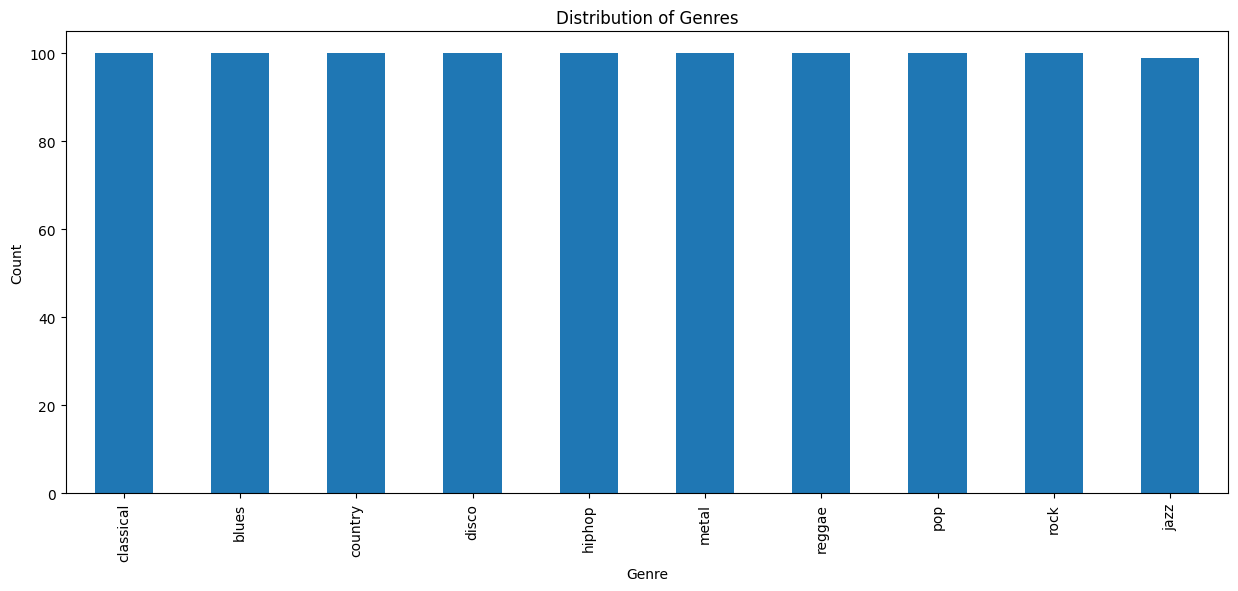

In [7]:
# Plot distribution of target
df["label"].value_counts().plot(kind="bar", figsize=(15, 6))
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Distribution of Genres");

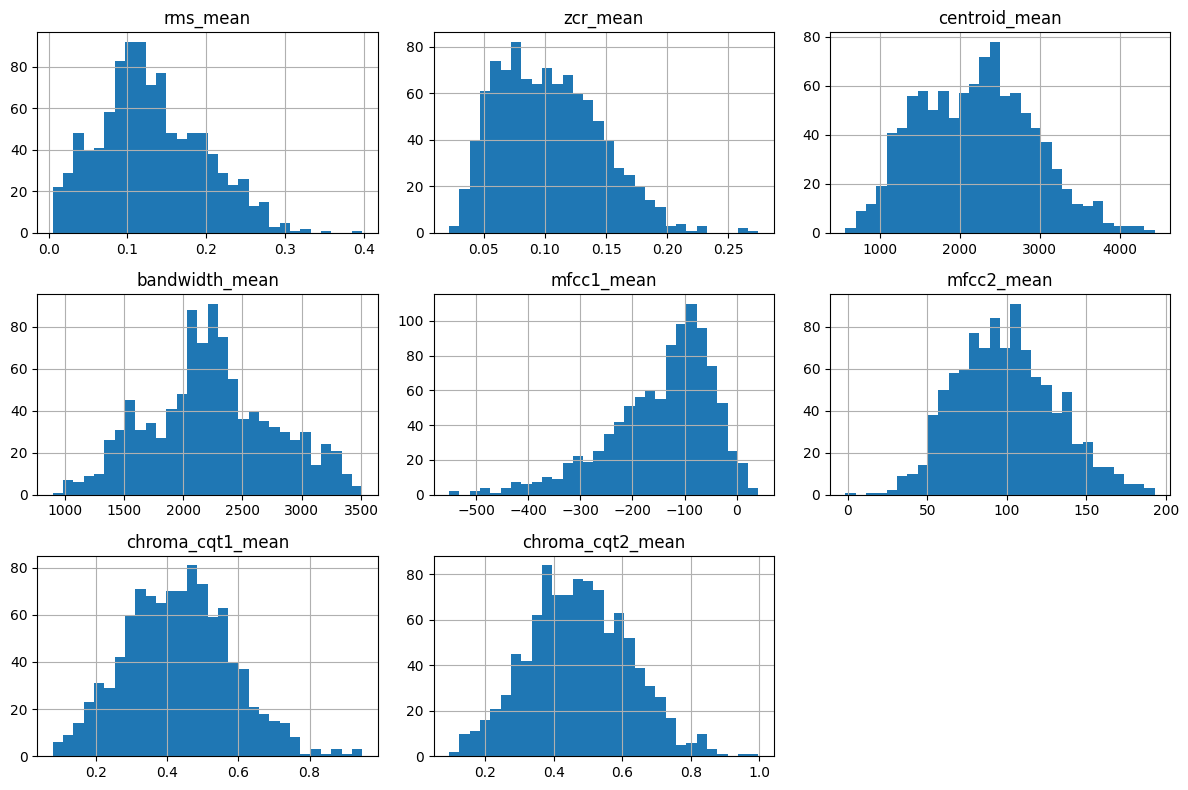

In [8]:
# Visualize a few features
features = ['rms_mean', 'zcr_mean', 'centroid_mean', 'bandwidth_mean', 'mfcc1_mean', 'mfcc2_mean', "chroma_cqt1_mean", "chroma_cqt2_mean"]

# Plot histograms
df[features].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

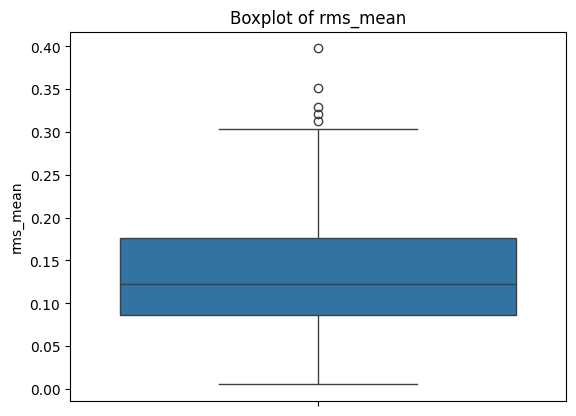

In [9]:
# Boxplot of rms_mean
sns.boxplot(df["rms_mean"])
plt.title("Boxplot of rms_mean")
plt.show()

/tmp/ipykernel_5186/3266588326.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="rms_mean", data=df, palette="Set2", legend=False)


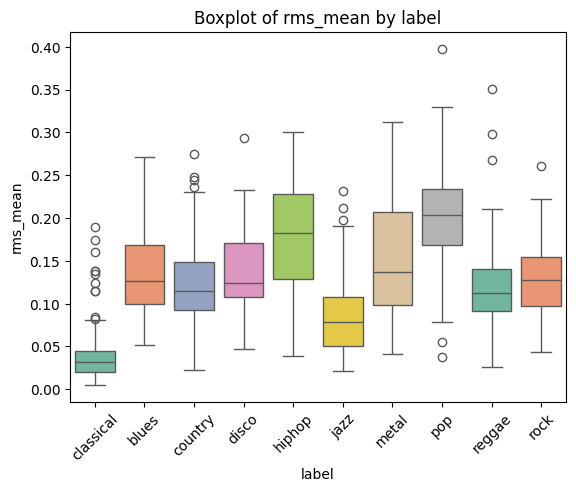

In [10]:
# Boxplot of feature vs target label
sns.boxplot(x="label", y="rms_mean", data=df, palette="Set2", legend=False)
plt.title("Boxplot of rms_mean by label")
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_5186/1468942523.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="centroid_mean", data=df, palette="Set2", legend=False)


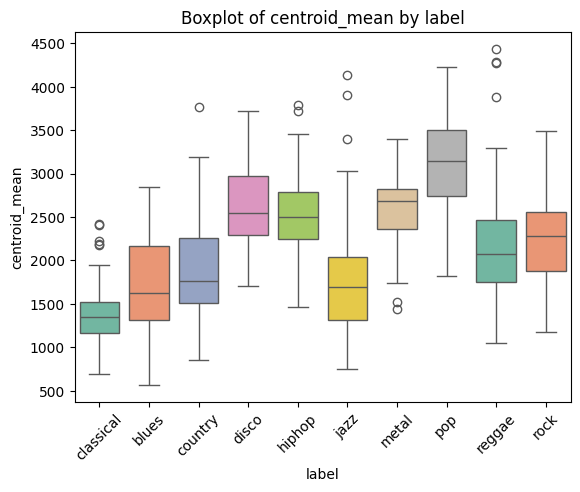

In [11]:
# Boxplot of feature vs target label
sns.boxplot(x="label", y="centroid_mean", data=df, palette="Set2", legend=False)
plt.title("Boxplot of centroid_mean by label")
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_5186/3750018835.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="mfcc1_mean", data=df, palette="Set2", legend=False)


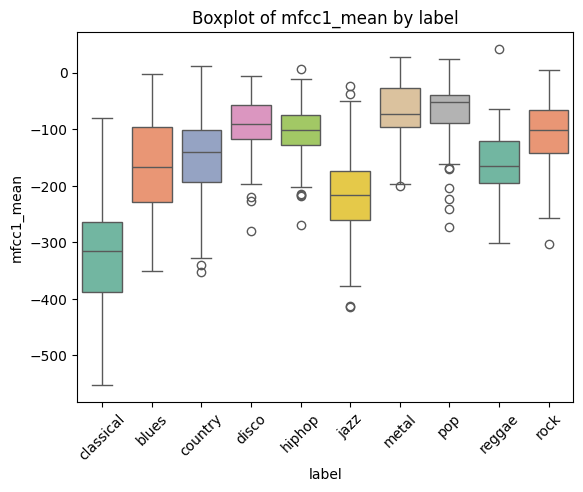

In [12]:
# Boxplot of feature vs target label
sns.boxplot(x="label", y="mfcc1_mean", data=df, palette="Set2", legend=False)
plt.title("Boxplot of mfcc1_mean by label")
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_5186/794332449.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="chroma_cqt2_mean", data=df, palette="Set2", legend=False)


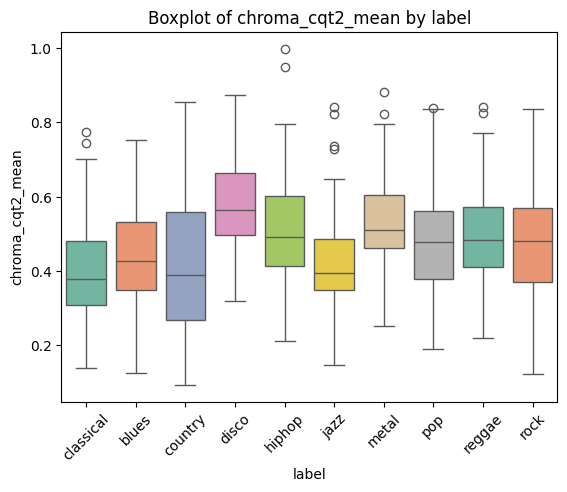

In [13]:
# Boxplot of feature vs target label
sns.boxplot(x="label", y="chroma_cqt2_mean", data=df, palette="Set2", legend=False)
plt.title("Boxplot of chroma_cqt2_mean by label")
plt.xticks(rotation=45)
plt.show()

In [14]:
# Summary statistics
df[features].describe()

,rms_mean,zcr_mean,centroid_mean,bandwidth_mean,mfcc1_mean,mfcc2_mean,chroma_cqt1_mean,chroma_cqt2_mean
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.130826,0.103651,2202.419119,2242.763943,-144.530189,99.531221,0.433165,0.473495
std,0.065671,0.041824,716.076969,526.517009,100.263519,31.331607,0.148377,0.148306
min,0.005270,0.021697,570.349904,900.409298,-552.158600,-1.471577,0.080103,0.094103
25%,0.086566,0.070374,1626.527014,1907.133128,-200.912970,76.771480,0.328013,0.370947
50%,0.122181,0.099503,2209.486740,2221.373053,-120.349420,98.435830,0.435921,0.470166
75%,0.175621,0.132097,2691.962733,2578.883006,-73.818312,119.790992,0.530027,0.578353
max,0.397734,0.274631,4435.732059,3509.656096,42.091450,193.074460,0.947777,0.998194


<div style="font-size: 20px; font-weight: bold">Multivariate Analysis</div>

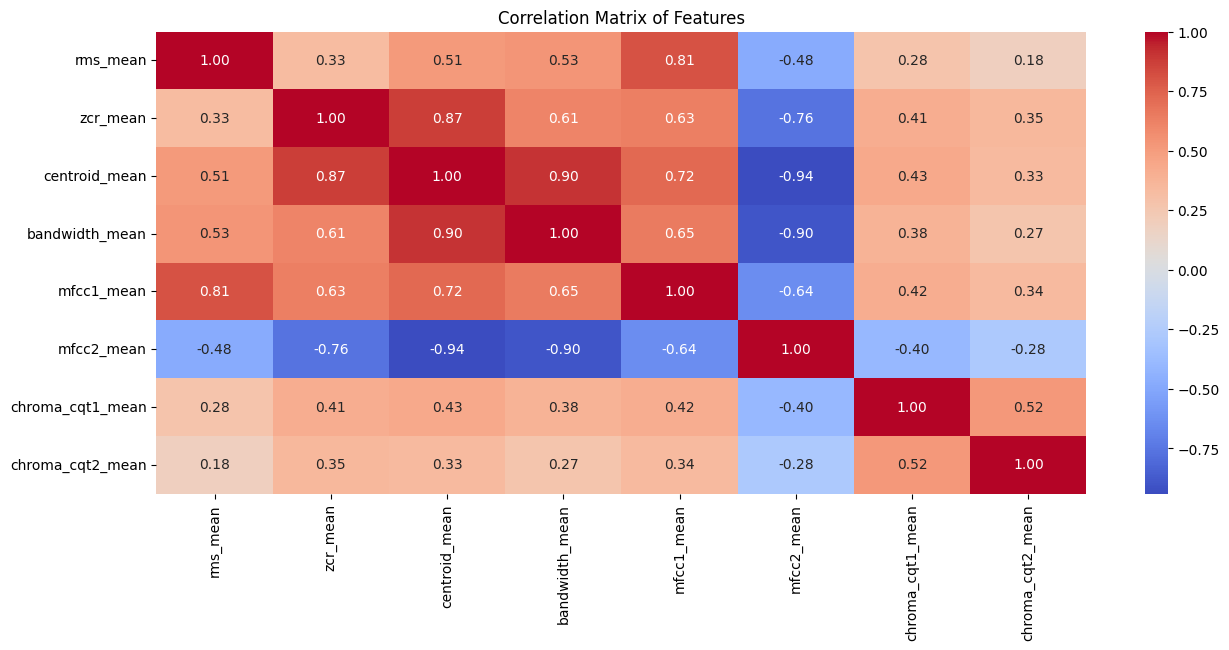

In [15]:
# Correlation matrix for numerical features
corr = df[features].corr()
# Plot heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Matrix of Features")
plt.show()

<div style="font-size: 20px; font-weight: bold">Splitting</div>

In [16]:
# Split into feature matrix and target vector
target = "label"
X = df.drop(columns=["filename", "label"])
y = df[target]
# Check shapes
print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")

Feature shape: (999, 222)
Target shape: (999,)


In [17]:
# Perform a stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
# Check results
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (799, 222)
y_train shape: (799,)
X_test shape: (200, 222)
y_test shape: (200,)


<div style="font-size: 20px; font-weight: bold">Feature Scaling</div>

In [19]:
# Instantiate and fit scaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# Confirm scaling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns) 
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns) 

In [21]:
X_train_scaled_df.shape

(799, 222)

In [22]:
X_test_scaled_df.shape

(200, 222)

In [88]:
y_test.nunique()

10

In [23]:
# Mean should be close to zero
print(f"X_train_scaled_df mean: {X_train_scaled_df.mean(axis=0)}")
# Std should be close to one
print(f"X_train_scaled_df std: {X_train_scaled_df.std(axis=0)}")

X_train_scaled_df mean: rms_mean                 5.335740e-17
rms_std                 -1.333935e-17
rms_max                  9.782190e-17
rms_min                 -9.893352e-17
rms_skew                 1.111613e-17
                             ...     
chroma_cqt11_std         2.756799e-16
chroma_cqt11_min        -1.022684e-16
chroma_cqt11_max         2.674540e-15
chroma_cqt11_skew       -7.114320e-17
chroma_cqt11_kurtosis    4.446450e-18
Length: 222, dtype: float64
X_train_scaled_df std: rms_mean                 1.000626
rms_std                  1.000626
rms_max                  1.000626
rms_min                  1.000626
rms_skew                 1.000626
                           ...   
chroma_cqt11_std         1.000626
chroma_cqt11_min         1.000626
chroma_cqt11_max         1.000626
chroma_cqt11_skew        1.000626
chroma_cqt11_kurtosis    1.000626
Length: 222, dtype: float64


<div style="text-align: center; font-size: 30px">ML CLASSIFICATION REVIEW & BASELINE MODELING</div>

<div style="font-size: 20px; font-weight: bold">Logistic Regression</div>

In [24]:
# Instantiate
log_reg = LogisticRegression(max_iter=1000)

In [25]:
# Instantiate logistic regressor
log_reg = LogisticRegression(max_iter=1000)

# Fit model
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [26]:
# Make predictions
y_pred_log_reg = log_reg.predict(X_test_scaled)

In [27]:
# Evaluate results
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")
print(f"Logistic Regression Classification Report: {classification_report(y_test, y_pred_log_reg)}")

Logistic Regression Accuracy: 0.785
Logistic Regression Classification Report:               precision    recall  f1-score   support

       blues       0.89      0.80      0.84        20
   classical       0.95      0.90      0.92        20
     country       0.75      0.75      0.75        20
       disco       0.79      0.75      0.77        20
      hiphop       0.73      0.80      0.76        20
        jazz       0.95      0.95      0.95        20
       metal       0.90      0.90      0.90        20
         pop       0.80      0.80      0.80        20
      reggae       0.73      0.55      0.63        20
        rock       0.48      0.65      0.55        20

    accuracy                           0.79       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.80      0.79      0.79       200



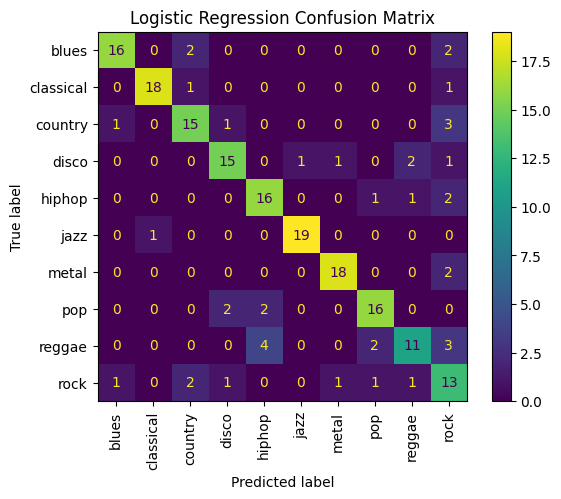

In [28]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log_reg, xticks_rotation='vertical')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

<div style="font-size: 20px; font-weight: bold">KNeighborsClassifier</div>

In [29]:
# Instantiate and fit
k_neighbors = KNeighborsClassifier(n_neighbors=11)
k_neighbors.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=11)

In [30]:
# Make predictions
y_pred_k_neighbors = k_neighbors.predict(X_test_scaled)

In [31]:
# Evaluation
print(f"KNeighborsClassifier Accuracy: {accuracy_score(y_test, y_pred_k_neighbors)}")
print(f"KNeighborsClassifier Classification Report: {classification_report(y_test, y_pred_k_neighbors)}")

KNeighborsClassifier Accuracy: 0.695
KNeighborsClassifier Classification Report:               precision    recall  f1-score   support

       blues       0.88      0.75      0.81        20
   classical       1.00      0.70      0.82        20
     country       0.59      0.85      0.69        20
       disco       0.44      0.80      0.57        20
      hiphop       0.77      0.50      0.61        20
        jazz       0.72      0.90      0.80        20
       metal       0.93      0.65      0.76        20
         pop       0.76      0.80      0.78        20
      reggae       0.86      0.60      0.71        20
        rock       0.47      0.40      0.43        20

    accuracy                           0.69       200
   macro avg       0.74      0.69      0.70       200
weighted avg       0.74      0.69      0.70       200



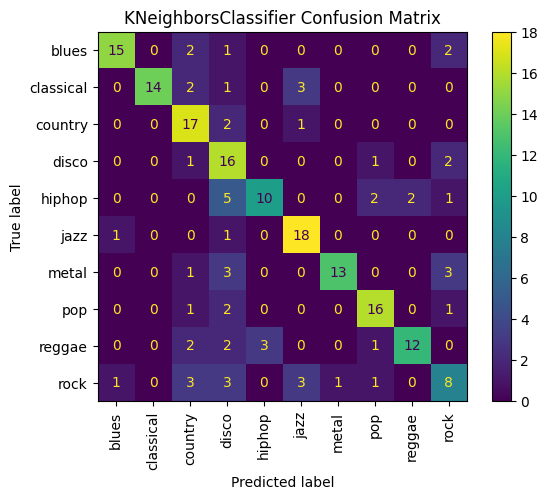

In [32]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_k_neighbors, xticks_rotation='vertical')
plt.title("KNeighborsClassifier Confusion Matrix")
plt.show()

<div style="font-size: 20px; font-weight: bold">Support Vector Machines(SVMs)</div>

In [33]:
# Instantiate and fit
svc = SVC(kernel="rbf", C=1.0, gamma="scale")
svc.fit(X_train_scaled, y_train)

SVC()

In [34]:
# Make Predictions
y_pred_svc = svc.predict(X_test_scaled)

In [35]:
# Evaluation
print(f"SVC accuracy: {accuracy_score(y_test, y_pred_svc)}")
print(f"SVC classification report: {classification_report(y_test, y_pred_svc)}")

SVC accuracy: 0.805
SVC classification report:               precision    recall  f1-score   support

       blues       0.89      0.85      0.87        20
   classical       0.85      0.85      0.85        20
     country       0.74      0.85      0.79        20
       disco       0.70      0.80      0.74        20
      hiphop       0.80      0.80      0.80        20
        jazz       0.82      0.90      0.86        20
       metal       0.90      0.90      0.90        20
         pop       0.89      0.80      0.84        20
      reggae       0.93      0.65      0.76        20
        rock       0.62      0.65      0.63        20

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200



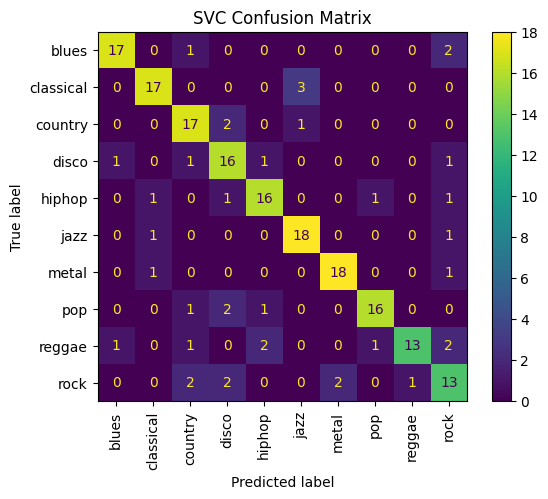

In [36]:
# Plot Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svc, xticks_rotation="vertical")
plt.title("SVC Confusion Matrix")
plt.show()

**Note**
- kernel = "linear" has an accuracy score of 79, this is the baseline

In [37]:
svc_tune = SVC()
# Perform a RandomizedCV on SVC
param_dist_svc = {
    "kernel": ["linear", "poly", "rbf"],
    "C": [1.0, 1.5, 2.0, 2.5],
    "gamma": ["auto", "scale"]
}

# Set up
random_search = RandomizedSearchCV(
    estimator=svc_tune,
    param_distributions=param_dist_svc,
    n_iter=20,
    verbose=1,
    cv=5,
    n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

print("Best params:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'kernel': 'rbf', 'gamma': 'scale', 'C': 2.0}
Best score: 0.7759984276729559


In [38]:
# Instatiate best model, Predict, Evaluate
best_svc = random_search.best_estimator_
best_svc_pred = best_svc.predict(X_test_scaled)

# Evaluation
print("Accuracy:", accuracy_score(y_test, best_svc_pred))

Accuracy: 0.825


In [39]:
print("\nClassification Report:\n", classification_report(y_test, best_svc_pred))


Classification Report:
               precision    recall  f1-score   support

       blues       0.89      0.85      0.87        20
   classical       0.86      0.90      0.88        20
     country       0.76      0.95      0.84        20
       disco       0.80      0.80      0.80        20
      hiphop       0.85      0.85      0.85        20
        jazz       0.86      0.95      0.90        20
       metal       0.94      0.85      0.89        20
         pop       0.88      0.75      0.81        20
      reggae       0.93      0.65      0.76        20
        rock       0.58      0.70      0.64        20

    accuracy                           0.82       200
   macro avg       0.84      0.82      0.83       200
weighted avg       0.84      0.82      0.83       200



<div style="font-size: 25px; font-weight: bold; color: red;">TREE-BASED MODELS, ENSEMBLES AND CROSS VALIDATION</div>

<div style="font-size: 20px; font-weight: bold">Decision Trees</div>

In [40]:
# Instantiate and Fit Classifier
clf = DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_leaf=1, min_samples_split=10, random_state=42)
clf.fit(X_train, y_train)
# Make Prediction
tree_pred = clf.predict(X_test)

In [41]:
y_train.unique()

array(['jazz', 'country', 'rock', 'hiphop', 'pop', 'reggae', 'metal',
       'blues', 'classical', 'disco'], dtype=object)

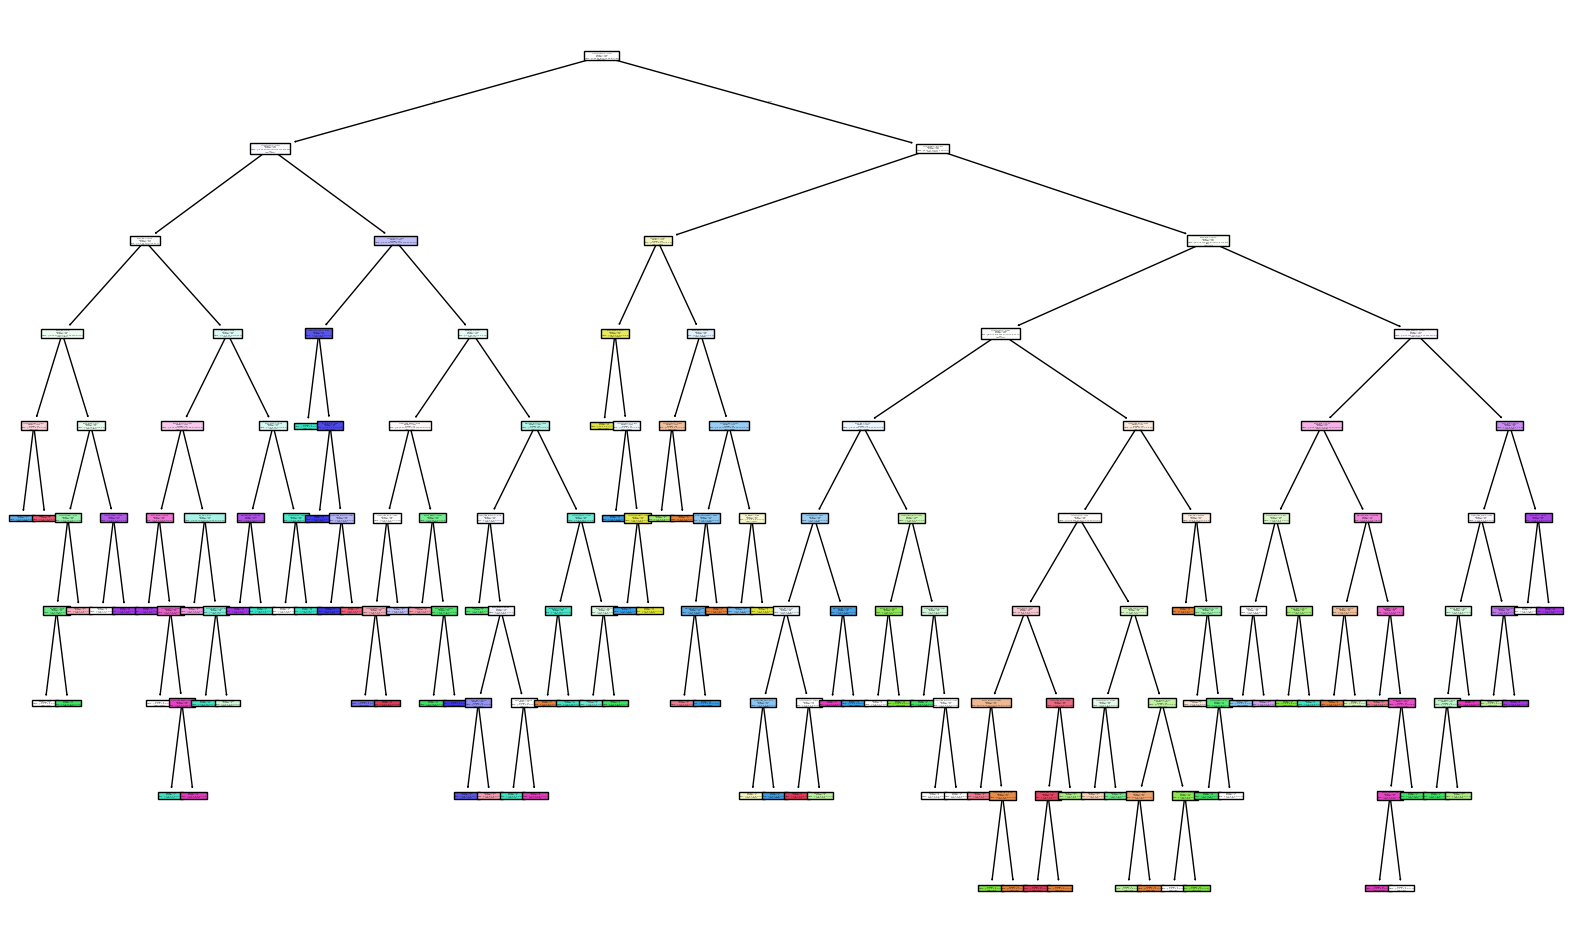

In [42]:
# Visualize the Decision Making
plt.figure(figsize=(20, 12))
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=y_train.unique())
plt.show()

In [43]:
# Hyper-parameter Tuning
# param_grid = {
#     "criterion": ["gini", "entropy"],
#     "max_depth": [3, 5, 7, 10, 13],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4]
# }

# # Set up grid search
# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring="accuracy")
# grid_search.fit(X_train, y_train)

# # Best tree
# best_tree = grid_search.best_estimator_
# print(f"Best parameters: {grid_search.best_params_}")

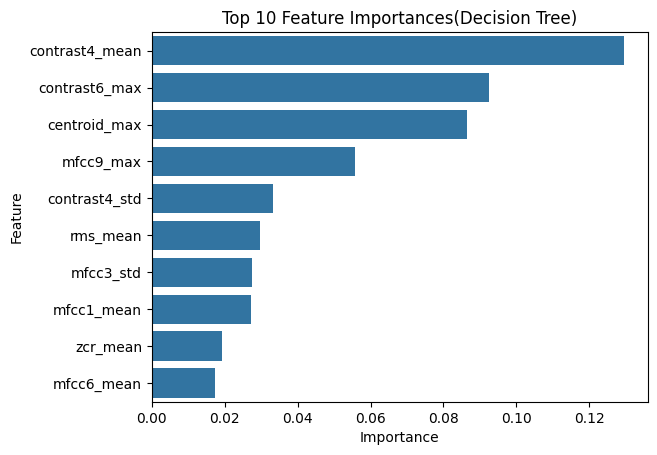

In [44]:
# Plot Feature Importances
importances = clf.feature_importances_

# Plot 10 most important features
df = pd.DataFrame({"Feature": X_train.columns, "Importance": importances})
sns.barplot(x="Importance", y="Feature", data=df.sort_values(by="Importance", ascending=False).head(10))
plt.title("Top 10 Feature Importances(Decision Tree)")
plt.show()

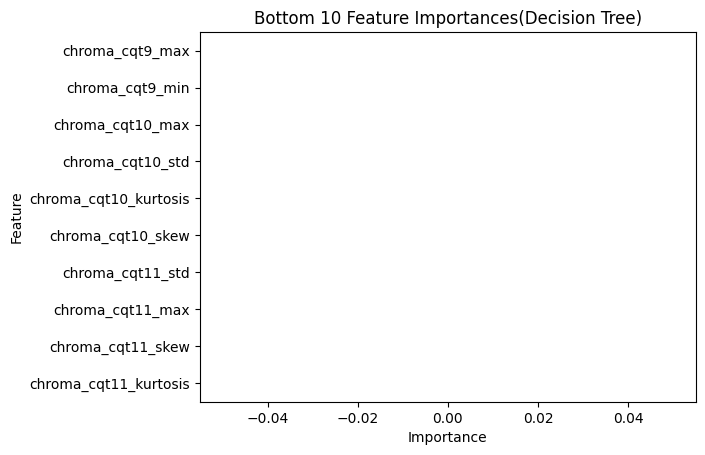

In [45]:
sns.barplot(x="Importance", y="Feature", data=df.sort_values(by="Importance", ascending=False).tail(10))
plt.title("Bottom 10 Feature Importances(Decision Tree)")
plt.show()

In [46]:
# Estract the predictions of the best tree
best_tree_pred = clf.predict(X_test)

In [47]:
# Evaluation
print(f"Best tree accuracy:", accuracy_score(y_test, best_tree_pred))
print(f"First tree accuracy:", accuracy_score(y_test, tree_pred))

Best tree accuracy: 0.54
First tree accuracy: 0.54


In [48]:
# Classification report
print(f"Best tree classification report:", classification_report(y_test, best_tree_pred))

Best tree classification report:               precision    recall  f1-score   support

       blues       0.46      0.55      0.50        20
   classical       0.87      0.65      0.74        20
     country       0.37      0.50      0.43        20
       disco       0.33      0.30      0.32        20
      hiphop       0.42      0.40      0.41        20
        jazz       0.58      0.75      0.65        20
       metal       0.95      0.90      0.92        20
         pop       0.72      0.65      0.68        20
      reggae       0.50      0.55      0.52        20
        rock       0.25      0.15      0.19        20

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.54      0.54      0.54       200



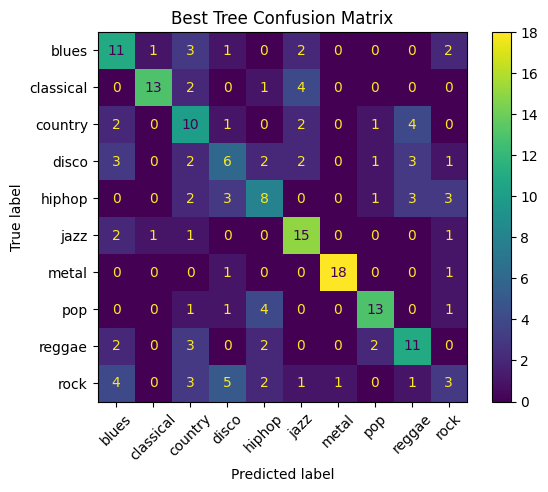

In [49]:
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, tree_pred, xticks_rotation=45)
plt.title("Best Tree Confusion Matrix")
plt.show()

In [50]:
y_train_pred = clf.predict(X_train)

In [51]:
# Is the tree overfitting?
print(f"Best tree training accuracy:", accuracy_score(y_train, y_train_pred))
print(f"Best tree test accuracy:", accuracy_score(y_test, best_tree_pred))

Best tree training accuracy: 0.9086357947434293
Best tree test accuracy: 0.54


<div style="font-size: 20px; font-weight: bold">Random Forests</div>

In [52]:
# Instantiate
rf = RandomForestClassifier(
    n_estimators=120,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
# Fit the model
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, n_estimators=120, n_jobs=-1,
                       random_state=42)

In [53]:
# Make prediction
rf_pred = rf.predict(X_test_scaled)

In [54]:
# Evaluation
print(f'Random Forest accuracy:', accuracy_score(y_test, rf_pred))

Random Forest accuracy: 0.795


In [55]:
# # Hyper-parameter tuning
# grid = {
#     "n_estimators": [100, 120, 150, 170, 200],
#     "max_depth": [3, 5, 7, 10, 13, 15],
#     "min_samples_split": [2, 3, 5],
#     "min_samples_leaf": [1, 2, 3]
# }
# # Perform grid search and fit
# grid_search = GridSearchCV(estimator=rf, param_grid=grid, cv=5, n_jobs=-1, scoring="accuracy")
# grid_search.fit(X_train_scaled, y_train)
# # Extract best model and check best params
# best_rf = grid_search.best_estimator_
# print(f"Best Parameters:", grid_search.best_params_)

In [56]:
# Evaluate best
best_rf_pred = rf.predict(X_test_scaled)
print(f"Best Random Forest accuracy:", accuracy_score(y_test, best_rf_pred))

Best Random Forest accuracy: 0.795


In [57]:
# Classification report
print(f'Best Random Forest classification report:', classification_report(y_test, best_rf_pred))

Best Random Forest classification report:               precision    recall  f1-score   support

       blues       0.90      0.95      0.93        20
   classical       0.94      0.75      0.83        20
     country       0.82      0.90      0.86        20
       disco       0.82      0.70      0.76        20
      hiphop       0.84      0.80      0.82        20
        jazz       0.72      0.90      0.80        20
       metal       0.77      1.00      0.87        20
         pop       0.86      0.90      0.88        20
      reggae       0.60      0.60      0.60        20
        rock       0.69      0.45      0.55        20

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.79       200
weighted avg       0.80      0.80      0.79       200



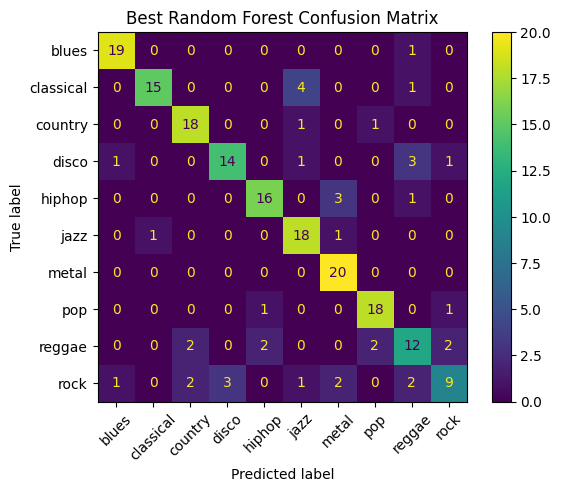

In [58]:
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, best_rf_pred, xticks_rotation=45)
plt.title("Best Random Forest Confusion Matrix")
plt.show()

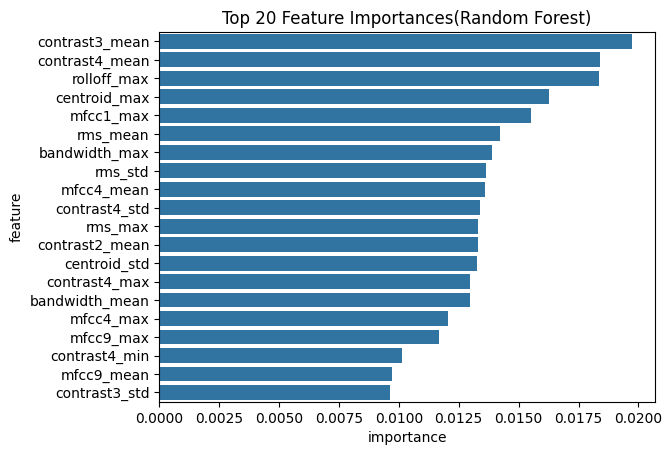

In [59]:
# rf feature importances
rf_importances = rf.feature_importances_
# Plot
rf_df = pd.DataFrame({"feature": X_train.columns, "importance": rf_importances})
sns.barplot(data=rf_df.sort_values(by="importance", ascending=False).head(20), x="importance", y="feature")
plt.title("Top 20 Feature Importances(Random Forest)")
plt.show()

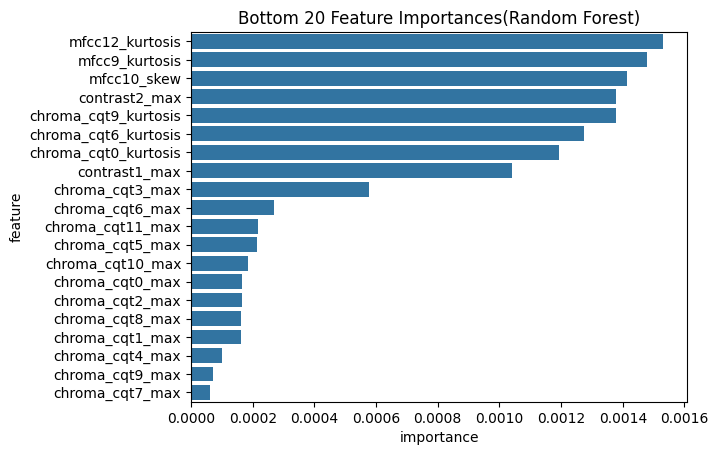

In [60]:
sns.barplot(data=rf_df.sort_values(by="importance", ascending=False).tail(20), x="importance", y="feature")
plt.title("Bottom 20 Feature Importances(Random Forest)")
plt.show()

In [61]:
rf_tune = RandomForestClassifier(random_state=42, n_jobs=-1)
# Perform a RandomizedCV on Random forest
param_dist_rf = {
    "n_estimators": [100, 120, 200],
    "max_depth": [5, 7, 10, 13, 15],
    "min_samples_split": [2, 3, 5],
    "min_samples_leaf": [1, 2, 3]
}

# Set up
rf_random_search = RandomizedSearchCV(
    estimator=rf_tune,
    param_distributions=param_dist_rf,
    n_iter=20,
    verbose=1,
    cv=5,
    n_jobs=-1
)
rf_random_search.fit(X_train_scaled, y_train)

print("Best params:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'kernel': 'rbf', 'gamma': 'scale', 'C': 2.0}
Best score: 0.7759984276729559


In [62]:
# Instatiate best model, Predict, Evaluate
best_rf = rf_random_search.best_estimator_
best_rf_pred = best_rf.predict(X_test_scaled)

# Evaluation
print("Accuracy:", accuracy_score(y_test, best_rf_pred))

Accuracy: 0.785


In [63]:
# Avanced Error Analysis and Classification
explainer = shap.Explainer(best_rf, X_train_scaled)
shap_values = explainer(X_test_scaled)

 99%|===================| 1987/2000 [00:51<00:00]        

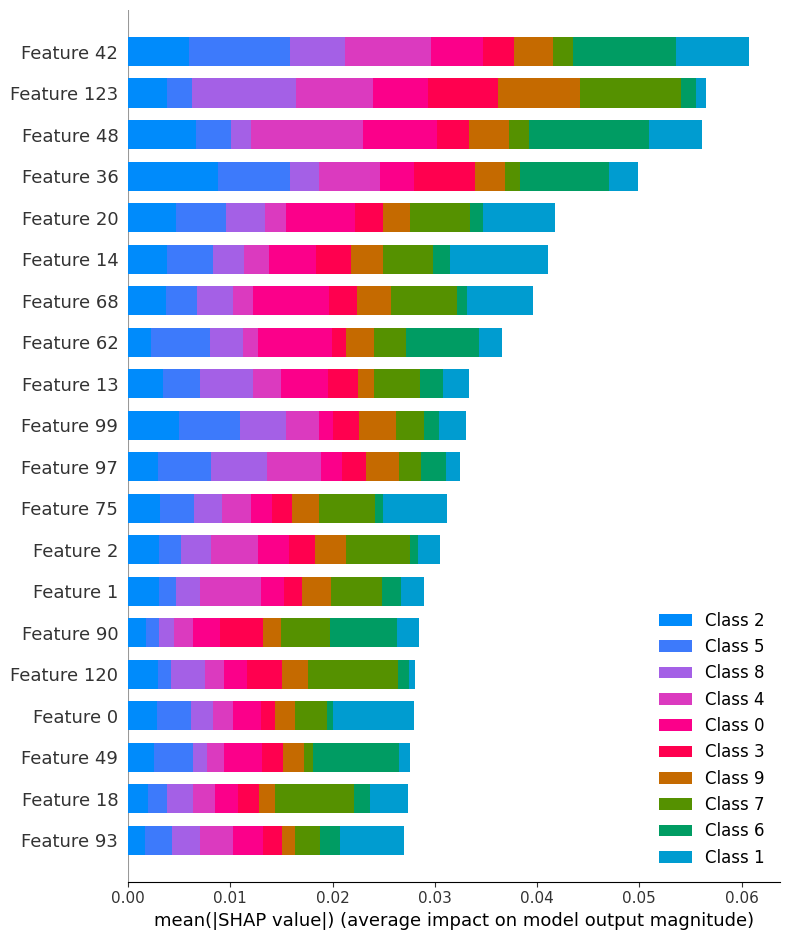

In [64]:
# Visualize the explanation
shap.summary_plot(shap_values, X_test_scaled)

In [72]:
# LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X_train.columns,
    class_names=y_train,
    mode='classification'
)

In [76]:
# Explain a single prediction
i = 0 # Index of sample
exp = lime_explainer.explain_instance(
    data_row=X_test_scaled[i],
    predict_fn=best_rf.predict_proba
)
print(exp.as_list())

[('centroid_max <= -0.68', 0.02414283365945924), ('contrast4_min > 0.37', 0.023710338681238393), ('mfcc1_max <= -0.43', 0.019255480905566356), ('contrast3_min > 0.43', 0.019065398170554325), ('contrast3_mean > 0.50', 0.017728849134239465), ('rolloff_max <= -0.42', 0.015737131033140516), ('mfcc4_max <= -0.75', 0.01455269560990832), ('bandwidth_max <= -0.62', 0.014530520871915038), ('contrast4_mean > 0.56', 0.013364381251312764), ('rms_mean <= -0.68', 0.012980484676068669)]


<div style="font-size: 20px; font-weight: bold">Gradient Boosting Machines(GBMs)</div>

In [75]:
# Instantiate
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=200, random_state=42)

In [ ]:
# Make predictions
gb_pred = gb.predict(X_test)

In [ ]:
# Evaluation
print(f'Gradient Boosting Machines accuracy:', accuracy_score(y_test, gb_pred))

**Notes**
- What if i trained the tree-based models using raw features(no standard scaling)? Ans: performance remains same

In [ ]:
# # Hyper-parameter tuning
# gb_param_grid = {
#     "n_estimators": [100, 200],
#     "learning_rate": [0.1, 1.0, 2.0],
#     "max_depth": [3, 4, 5],
# }
# # Set up grid search and fit
# grid_search = GridSearchCV(estimator=gb, param_grid=gb_param_grid, cv=5, n_jobs=-1, scoring="accuracy")
# grid_search.fit(X_train, y_train)
# # Extract best gbm
# best_gbm = grid_search.best_estimator_
# print(f'Best gbm parameters:', grid_search.best_params_)
# print(f'Best score:', grid_search.best_score_)

**Note**
- Above cell commented out to prevent rerunning

In [ ]:
best_gbm_pred = gb.predict(X_test)
# Evaluation
print(f'Gradient Boosting Machine accuracy:', accuracy_score(y_test, best_gbm_pred))

In [ ]:
gbm_tune = GradientBoostingClassifier(random_state=42)
# Perform a RandomizedCV on Random forest
param_dist_gbm = {
    "n_estimators": [100, 120, 150, 170, 200],
    "learning_rate": [0.1, 0.5, 1, 2],
    "max_depth": [3, 4, 5, 7],
}

# Set up
gbm_random_search = RandomizedSearchCV(
    estimator=gbm_tune,
    param_distributions=param_dist_gbm,
    n_iter=20,
    verbose=1,
    cv=5,
    n_jobs=-1
)
gbm_random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best score:", random_search.best_score_)

In [ ]:
# Make predictions
best_gbm = gbm_random_search.best_estimator_
gbm_best_pred = best_gbm.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, gbm_best_pred))

<div style="font-size: 20px; font-weight: bold; text-align: center">Cross-validation Deep Dive</div>

In [ ]:
# Instatiate
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Perform a cv on Random Forest Model
rf_cv = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
scores = cross_val_score(rf_cv, X_train_scaled, y_train, cv=cv, scoring="accuracy")
# Display Output
print(f"Random Forest CV scores:", scores)
print(f"Random Forest mean CV score:", np.mean(scores))

In [ ]:
# Perform cv on Gradient Boosting 
gb_scores = cross_val_score(gb, X_train_scaled, y_train, cv=cv, scoring="accuracy")
# Print output
print(f"Gradient Boosting CV scores:", gb_scores)
print(f"Gradient Boosting mean CV score:", np.mean(gb_scores))

In [ ]:
# Perform cv on Support Vector Classifier
svc_scores = cross_val_score(svc, X_train_scaled, y_train, cv=cv, scoring="accuracy")
# Print output
print(f"SVC CV scores:", svc_scores)
print(f"SVC mean CV score:", np.mean(svc_scores))

In [ ]:
# Perform cv on Logistic Regression
log_reg_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=cv, scoring="accuracy")
# Print output
print(f"Logistic Regression CV scores:", log_reg_scores)
print(f"Logistic Regression mean CV score:", np.mean(log_reg_scores))

<div style="text-align: center; color: red; font-weight: bold; font-size: 40px">FINAL MODEL</div>

In [77]:
# Instantiate final model
final_model = SVC(kernel='rbf',gamma='scale', C=2.0)
# Fit final model
final_model.fit(X_train_scaled, y_train)

SVC(C=2.0)

In [78]:
# Make final predictions
y_pred_final = final_model.predict(X_test_scaled)

In [79]:
# Final Model Evaluation
print("--- Final Model Evaluation on Test Set ---")
print("Final Accuracy:", accuracy_score(y_test, y_pred_final))
print("\nFinal Classification Report:\n", classification_report(y_test, y_pred_final))

--- Final Model Evaluation on Test Set ---
Final Accuracy: 0.825

Final Classification Report:
               precision    recall  f1-score   support

       blues       0.89      0.85      0.87        20
   classical       0.86      0.90      0.88        20
     country       0.76      0.95      0.84        20
       disco       0.80      0.80      0.80        20
      hiphop       0.85      0.85      0.85        20
        jazz       0.86      0.95      0.90        20
       metal       0.94      0.85      0.89        20
         pop       0.88      0.75      0.81        20
      reggae       0.93      0.65      0.76        20
        rock       0.58      0.70      0.64        20

    accuracy                           0.82       200
   macro avg       0.84      0.82      0.83       200
weighted avg       0.84      0.82      0.83       200



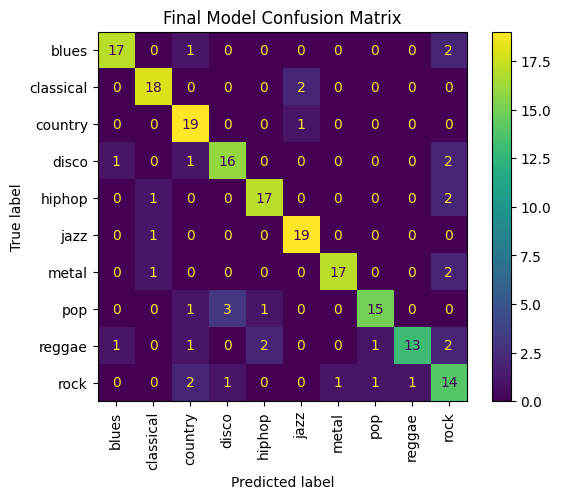

In [81]:
# Final model confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final, xticks_rotation='vertical')
plt.title('Final Model Confusion Matrix')
plt.show()

**Notes**
> Common confusion pairs:
>  Disco & Pop, Rock & Metal, Reggae, Hiphop, Disco, Blues, Hiphop & Reggae, Jazz & Classical

<div style="text-align: left; color: violet; font-weight: bold; font-size: 30px">Qualitative Analysis</div>

In [82]:
# Find indices of misclassified tracks
misclassified_idx = np.where(y_test != y_pred_final)[0]

In [110]:
df = pd.DataFrame(y_test)
df.head()

,label
47,classical
186,blues
659,metal
587,jazz
190,blues


In [112]:
misclassified_idx

array([  4,  12,  19,  23,  25,  34,  41,  45,  50,  59,  70,  76,  82,
        88,  92,  99, 102, 105, 108, 109, 110, 118, 119, 124, 127, 132,
       136, 143, 150, 154, 161, 168, 183, 193, 198])

In [97]:
y_pred_final

array(['classical', 'blues', 'metal', 'jazz', 'rock', 'country', 'rock',
       'country', 'hiphop', 'jazz', 'blues', 'blues', 'country', 'blues',
       'rock', 'disco', 'reggae', 'jazz', 'disco', 'country', 'country',
       'metal', 'blues', 'jazz', 'blues', 'jazz', 'pop', 'reggae', 'jazz',
       'jazz', 'metal', 'country', 'jazz', 'hiphop', 'jazz', 'metal',
       'rock', 'hiphop', 'country', 'disco', 'reggae', 'metal', 'pop',
       'blues', 'jazz', 'classical', 'metal', 'classical', 'hiphop',
       'pop', 'rock', 'metal', 'hiphop', 'jazz', 'reggae', 'disco',
       'disco', 'classical', 'classical', 'hiphop', 'metal', 'reggae',
       'reggae', 'rock', 'disco', 'rock', 'rock', 'classical', 'rock',
       'pop', 'rock', 'reggae', 'classical', 'pop', 'reggae', 'hiphop',
       'blues', 'pop', 'pop', 'pop', 'disco', 'pop', 'rock', 'hiphop',
       'jazz', 'rock', 'reggae', 'hiphop', 'country', 'jazz', 'metal',
       'reggae', 'rock', 'disco', 'country', 'jazz', 'jazz', 'country',

**ISSUE**
- I don't think the filepaths are trackable, or i'm i overlooking something?